In [ ]:
!pip install scikit-surprise

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import precision_score, recall_score, f1_score
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
file_path = "/content/Movies.csv"
data_df = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(data_df.head())

   User ID            Title     Genre  Rating
0        1  Stranger Things     Drama     4.5
1        1     Breaking Bad  Thriller     4.8
2        1        The Crown     Drama     4.2
3        2      The Witcher   Fantasy     4.0
4        2       Mindhunter  Thriller     4.6


In [4]:
# Check for missing values
missing_values = data_df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 User ID    0
Title      0
Genre      0
Rating     0
dtype: int64


In [5]:
# Summary of numerical columns
summary = data_df.describe()
print("Summary of Numerical Columns:\n", summary)

Summary of Numerical Columns:
           User ID      Rating
count  150.000000  150.000000
mean    25.500000    4.492000
std     14.479214    0.253967
min      1.000000    4.000000
25%     13.000000    4.300000
50%     25.500000    4.500000
75%     38.000000    4.700000
max     50.000000    4.900000


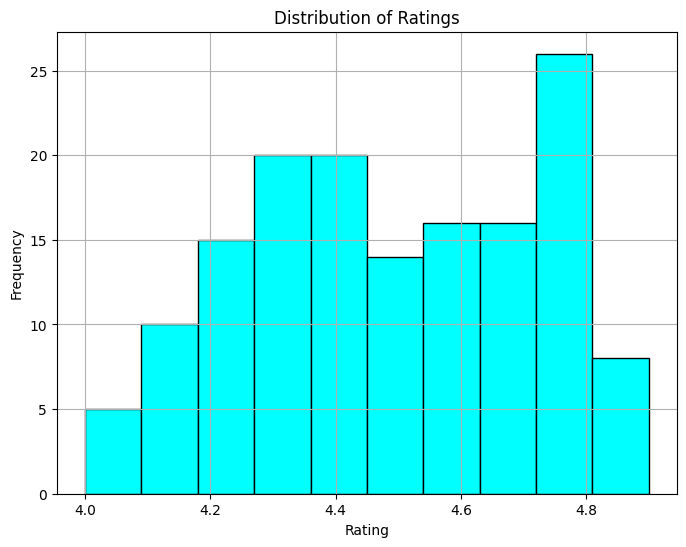

In [6]:
# Histogram of ratings
plt.figure(figsize=(8, 6))
plt.hist(data_df['Rating'], bins=10, color='cyan', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.grid(True)
plt.show()

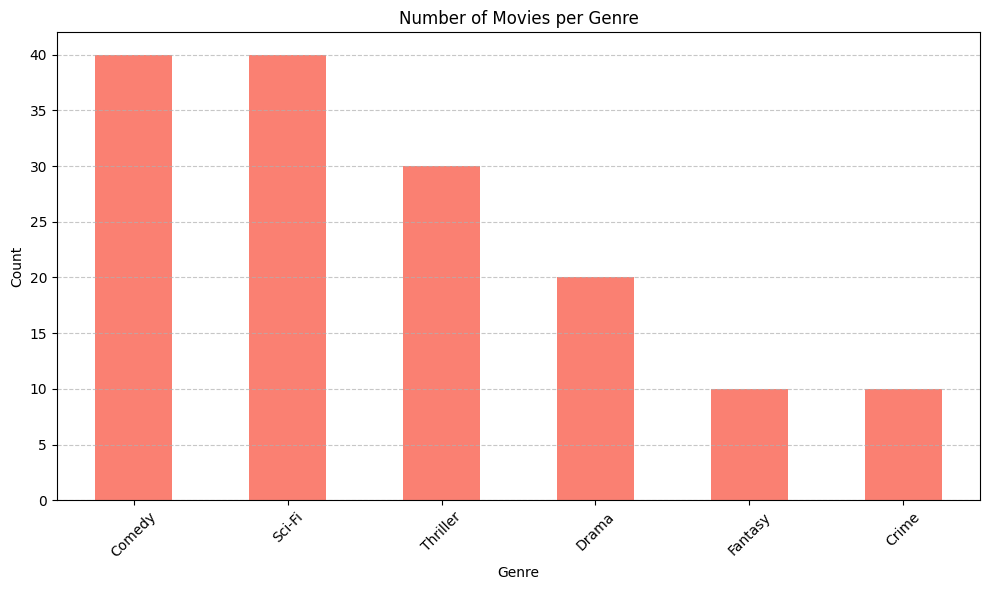

In [7]:
# Count of movies per genre
genre_counts = data_df['Genre'].value_counts()

# Bar plot for genres
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar', color='salmon')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Number of Movies per Genre')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<ipython-input-8-68cc2e3e1e01>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Genre', y='Rating', data=data_df, palette='viridis')


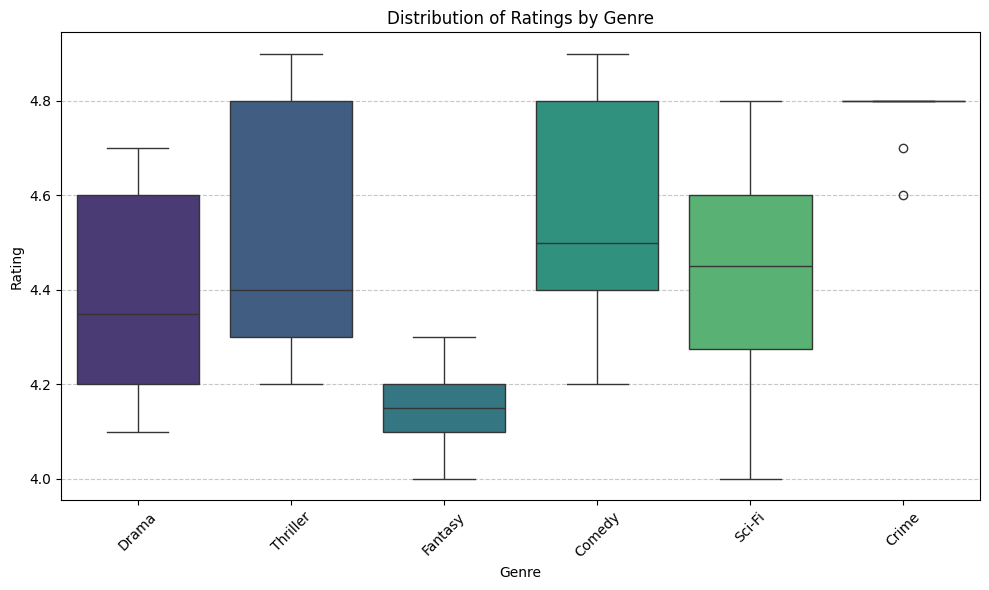

In [8]:
# Box plot of ratings by genre
plt.figure(figsize=(10, 6))
sns.boxplot(x='Genre', y='Rating', data=data_df, palette='viridis')
plt.xlabel('Genre')
plt.ylabel('Rating')
plt.title('Distribution of Ratings by Genre')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [9]:
#CONTENT-BASED FILTERING

movies_df = pd.read_csv(file_path)

tfidf = TfidfVectorizer(stop_words='english')
movies_df['Genre'] = movies_df['Genre'].fillna('')  # Fill any missing genres with empty string
tfidf_matrix = tfidf.fit_transform(movies_df['Genre'])

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

def get_recommendations(user_id, cosine_sim=cosine_sim):
    user_movies = movies_df[movies_df['User ID'] == user_id]
    movie_scores = {}

    for index, movie in user_movies.iterrows():
        movie_idx = movies_df.index[movies_df['Title'] == movie['Title']].tolist()[0]
        sim_scores = list(enumerate(cosine_sim[movie_idx]))

        for sim_movie_idx, score in sim_scores:
            if movies_df.iloc[sim_movie_idx]['Title'] in user_movies['Title'].values:
                continue

            if sim_movie_idx in movie_scores:
                movie_scores[sim_movie_idx] += score
            else:
                movie_scores[sim_movie_idx] = score

    sorted_movies = sorted(movie_scores.items(), key=lambda x: x[1], reverse=True)
    recommended_movies = []
    seen_movies = set()

    for movie_idx, _ in sorted_movies:
        title = movies_df.iloc[movie_idx]['Title']
        if title not in seen_movies:
            recommended_movies.append(title)
            seen_movies.add(title)

    return recommended_movies[:5]

user_id = int(input("Enter User ID: " ))
recommended_movies = get_recommendations(user_id)

print("\nRecommended movies for User ID", user_id, ":")
for i, movie in enumerate(recommended_movies, 1):
    print(f"{i}. {movie}")


Enter User ID: 7

Recommended movies for User ID 7 :
1. Mindhunter
2. Dark
3. Westworld
4. The Mandalorian
5. Stranger Things


In [10]:
# EVALUATION OF CONTENT-BASED FILTERING

true_ratings = movies_df[movies_df['User ID'] == 2]['Rating']

predicted_movies = recommended_movies[:len(true_ratings)]  # Predicted top movies
predicted_ratings = [movies_df[movies_df['Title'] == movie]['Rating'].values[0] for movie in predicted_movies]

true_labels = (true_ratings >= 4.5).astype(int)
predicted_labels = [(rating >= 4.5).astype(int) for rating in predicted_ratings]

precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print("Evaluation Metrics:")
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Evaluation Metrics:
Precision: 0.5
Recall: 1.0
F1-score: 0.6666666666666666


In [11]:
# COLLABORATIVE FILTERING

df = pd.read_csv(file_path)
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['User ID', 'Title', 'Rating']], reader)

trainset, _ = train_test_split(data, test_size=0.2)

sim_options = {
    'name': 'cosine',
    'user_based': False
}

model = KNNBasic(sim_options=sim_options)
model.fit(trainset)

def get_recommendations_for_user(user_id, n=5):
    rated_movies = df[df['User ID'] == user_id]['Title'].tolist()
    user_inner_id = trainset.to_inner_uid(user_id)
    all_item_ids = list(trainset.all_items())
    unrated_item_ids = [item_id for item_id in all_item_ids if item_id not in trainset.ur[user_inner_id]]
    predictions = [model.predict(user_id, iid, verbose=False) for iid in unrated_item_ids]
    predictions.sort(key=lambda x: x.est, reverse=True)
    top_n = predictions[:n]
    recommendations = [(trainset.to_raw_iid(pred.iid), pred.est) for pred in top_n]
    recommendations = [(title, rating) for title, rating in recommendations if title not in rated_movies]
    return recommendations

user_id = int(input("\nEnter User ID: " ))
recommendations = get_recommendations_for_user(user_id)

print(f"\nRecommended movies for User ID {user_id}:")
for title, rating in recommendations:
    print(f"{title}")


Computing the cosine similarity matrix...
Done computing similarity matrix.

Enter User ID: 7

Recommended movies for User ID 7:
Westworld
Dark
The Witcher


In [12]:
# EVALUATION OF COLLABORATIVE FILTERING

def evaluate_model(predictions, threshold=3.5):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    precisions = dict()
    recalls = dict()
    f1_scores = dict()

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        n_rec_k = sum((est >= threshold) for (_, est) in user_ratings)
        n_rel_and_rec_k = sum((est >= threshold) for (_, est) in user_ratings)
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
        recalls[uid] = n_rel_and_rec_k / len(user_ratings)
        f1_scores[uid] = 2 * (precisions[uid] * recalls[uid]) / (precisions[uid] + recalls[uid]) if (precisions[uid] + recalls[uid]) != 0 else 0

    avg_precision = sum(prec for prec in precisions.values()) / len(precisions)
    avg_recall = sum(rec for rec in recalls.values()) / len(recalls)
    avg_f1_score = sum(f1 for f1 in f1_scores.values()) / len(f1_scores)

    return avg_precision, avg_recall, avg_f1_score

testset = trainset.build_testset()
predictions = model.test(testset)

avg_precision, avg_recall, avg_f1_score = evaluate_model(predictions)

print("Evaluation Metrics:")
print("Average Precision:", avg_precision)
print("Average Recall:", avg_recall)
print("Average F1-Score:", avg_f1_score)


Evaluation Metrics:
Average Precision: 1.0
Average Recall: 1.0
Average F1-Score: 1.0


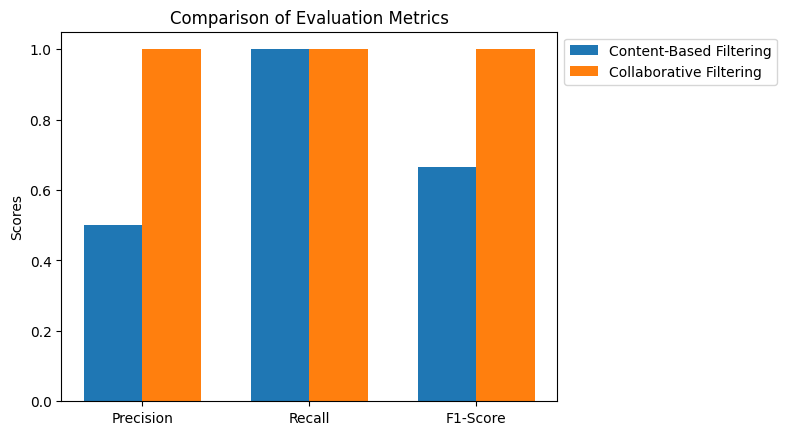

In [13]:
# COMPARISON OF PERFORMANCE OF DIFFERENCE ALGORITHMS

labels = ['Precision', 'Recall', 'F1-Score']
cb_scores = [precision, recall, f1]
cf_scores = [avg_precision, avg_recall, avg_f1_score]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, cb_scores, width, label='Content-Based Filtering')
rects2 = ax.bar(x + width/2, cf_scores, width, label='Collaborative Filtering')

ax.set_ylabel('Scores')
ax.set_title('Comparison of Evaluation Metrics')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.show()